In [1]:
!pip install pandas

In [2]:
import os
import shutil


import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
%matplotlib Inline
import seaborn as sns

In [3]:
df = pd.read_csv('animes.csv',usecols=['synopsis', 'genre'])

df.head()

,synopsis,genre
0,Following their participation at the Inter-Hig...,"['Comedy', 'Sports', 'Drama', 'School', 'Shoun..."
1,Music accompanies the path of the human metron...,"['Drama', 'Music', 'Romance', 'School', 'Shoun..."
2,The Abyss—a gaping chasm stretching down into ...,"['Sci-Fi', 'Adventure', 'Mystery', 'Drama', 'F..."
3,"""In order for something to be obtained, someth...","['Action', 'Military', 'Adventure', 'Comedy', ..."
4,After helping revive the legendary vampire Kis...,"['Action', 'Mystery', 'Supernatural', 'Vampire']"


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19311 entries, 0 to 19310
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   synopsis  18336 non-null  object
 1   genre     19311 non-null  object
dtypes: object(2)
memory usage: 301.9+ KB


In [5]:
df.dropna(subset = ['synopsis'], inplace=True)
df = df.drop_duplicates(subset = 'synopsis')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15191 entries, 0 to 19006
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   synopsis  15191 non-null  object
 1   genre     15191 non-null  object
dtypes: object(2)
memory usage: 356.0+ KB


In [7]:
#imprinting pprint for pretty printing
from pprint import pprint
#importing defaultdict
from collections import defaultdict
#saving total genres here.
hash_map = defaultdict(lambda: 0)
#saving each row's genre in genrelist
genrelist = []
for text in df['genre']:
    templist = text[2:len(text)-2].split("', '")
    for i in range(len(templist)):
        if templist[i] == '':
            templist.pop(i)
            break
    genrelist.append(templist)
    for j in templist:
        hash_map[j] += 1
        
# Adding genrelist Column
df['genrelist'] = genrelist

pprint(len(hash_map))
pprint(hash_map)

43
defaultdict(<function <lambda> at 0x0000016CCB68D3A0>,
            {'Action': 3390,
             'Adventure': 2614,
             'Cars': 110,
             'Comedy': 5310,
             'Dementia': 344,
             'Demons': 428,
             'Drama': 2390,
             'Ecchi': 718,
             'Fantasy': 2764,
             'Game': 336,
             'Harem': 366,
             'Hentai': 1154,
             'Historical': 989,
             'Horror': 420,
             'Josei': 92,
             'Kids': 2233,
             'Magic': 971,
             'Martial Arts': 344,
             'Mecha': 1010,
             'Military': 518,
             'Music': 1800,
             'Mystery': 645,
             'Parody': 592,
             'Police': 232,
             'Psychological': 318,
             'Romance': 1726,
             'Samurai': 187,
             'School': 1513,
             'Sci-Fi': 2360,
             'Seinen': 778,
             'Shoujo': 652,
             'Shoujo Ai': 72,
             'Shou

<Axes: >

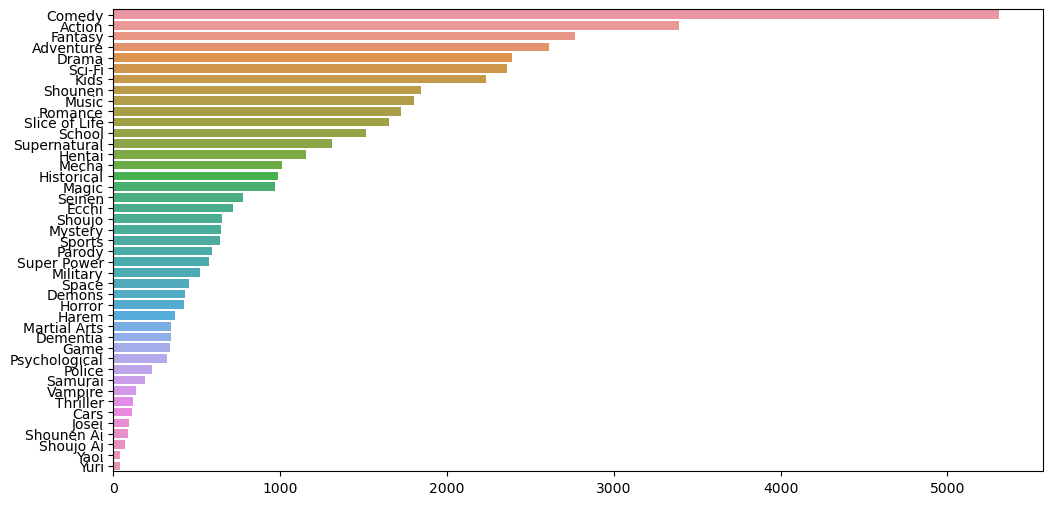

In [8]:

temp = list(hash_map.items())
temp.sort(key=lambda x: x[1], reverse=True)
plt.rcParams['figure.figsize'] = (12, 6)
y,x = [temp[i][0] for i in range(len(temp))], [temp[i][1] for i in range(len(temp))]
sns.barplot(x=x, y=y)

In [9]:
df.drop(columns=['genre'], inplace=True)

In [10]:
df

,synopsis,genrelist
0,Following their participation at the Inter-Hig...,"[Comedy, Sports, Drama, School, Shounen]"
1,Music accompanies the path of the human metron...,"[Drama, Music, Romance, School, Shounen]"
2,The Abyss—a gaping chasm stretching down into ...,"[Sci-Fi, Adventure, Mystery, Drama, Fantasy]"
3,"""In order for something to be obtained, someth...","[Action, Military, Adventure, Comedy, Drama, M..."
4,After helping revive the legendary vampire Kis...,"[Action, Mystery, Supernatural, Vampire]"
...,...,...
19002,All-new animation offered throughout UNIQLO cl...,"[Action, Comedy, Super Power, Martial Arts, Sh..."
19003,High school student Sora Kashiwagi is accustom...,"[Slice of Life, Comedy, Supernatural]"
19004,"After regaining her squid-like abilities, Ika ...","[Slice of Life, Comedy, Shounen]"
19005,"For years, the Niflheim Empire and the kingdom...",[Action]


In [11]:
import re

# Function for cleaning the text
def clean_text(text):
    text = re.sub('\'', "", text)
    text = re.sub('[^a-zA-Z]', " ", text)
    text = ' '.join(text.split())
    text = text.lower()
    return text

In [12]:
df.loc[:, 'cleaned_syn'] = df.loc[:,'synopsis'].apply(clean_text)
df

,synopsis,genrelist,cleaned_syn
0,Following their participation at the Inter-Hig...,"[Comedy, Sports, Drama, School, Shounen]",following their participation at the inter hig...
1,Music accompanies the path of the human metron...,"[Drama, Music, Romance, School, Shounen]",music accompanies the path of the human metron...
2,The Abyss—a gaping chasm stretching down into ...,"[Sci-Fi, Adventure, Mystery, Drama, Fantasy]",the abyss a gaping chasm stretching down into ...
3,"""In order for something to be obtained, someth...","[Action, Military, Adventure, Comedy, Drama, M...",in order for something to be obtained somethin...
4,After helping revive the legendary vampire Kis...,"[Action, Mystery, Supernatural, Vampire]",after helping revive the legendary vampire kis...
...,...,...,...
19002,All-new animation offered throughout UNIQLO cl...,"[Action, Comedy, Super Power, Martial Arts, Sh...",all new animation offered throughout uniqlo cl...
19003,High school student Sora Kashiwagi is accustom...,"[Slice of Life, Comedy, Supernatural]",high school student sora kashiwagi is accustom...
19004,"After regaining her squid-like abilities, Ika ...","[Slice of Life, Comedy, Shounen]",after regaining her squid like abilities ika m...
19005,"For years, the Niflheim Empire and the kingdom...",[Action],for years the niflheim empire and the kingdom ...


In [13]:
#importing nltk libraries
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to C:\Users\shaun
[nltk_data]     cheong\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [14]:
### Python Script to remove stopwords
stop_words = set(stopwords.words('english'))
stop_words.add('source')
words = defaultdict(lambda: 0)
def rem_stop(text):
    for i in text.split():
        new_text = []
        if i not in stop_words:
            new_text.append(i)
            words[i] += 1
    new_text = [i for i in text.split() if not i in stop_words]
    return ' '.join(new_text)

df.loc[:, 'cleaned_syn'] = df.loc[:, 'cleaned_syn'].apply(rem_stop)
df

,synopsis,genrelist,cleaned_syn
0,Following their participation at the Inter-Hig...,"[Comedy, Sports, Drama, School, Shounen]",following participation inter high karasuno hi...
1,Music accompanies the path of the human metron...,"[Drama, Music, Romance, School, Shounen]",music accompanies path human metronome prodigi...
2,The Abyss—a gaping chasm stretching down into ...,"[Sci-Fi, Adventure, Mystery, Drama, Fantasy]",abyss gaping chasm stretching depths earth fil...
3,"""In order for something to be obtained, someth...","[Action, Military, Adventure, Comedy, Drama, M...",order something obtained something equal value...
4,After helping revive the legendary vampire Kis...,"[Action, Mystery, Supernatural, Vampire]",helping revive legendary vampire kiss shot ace...
...,...,...,...
19002,All-new animation offered throughout UNIQLO cl...,"[Action, Comedy, Super Power, Martial Arts, Sh...",new animation offered throughout uniqlo clothi...
19003,High school student Sora Kashiwagi is accustom...,"[Slice of Life, Comedy, Supernatural]",high school student sora kashiwagi accustomed ...
19004,"After regaining her squid-like abilities, Ika ...","[Slice of Life, Comedy, Shounen]",regaining squid like abilities ika musume plan...
19005,"For years, the Niflheim Empire and the kingdom...",[Action],years niflheim empire kingdom lucis war empire...


In [15]:
tmp = sorted(words, key = lambda x: words[x], reverse = True)

In [16]:
#total words
values = []
for i in tmp:
    values.append(words[i])
print(sum(values))

570815


<Axes: >

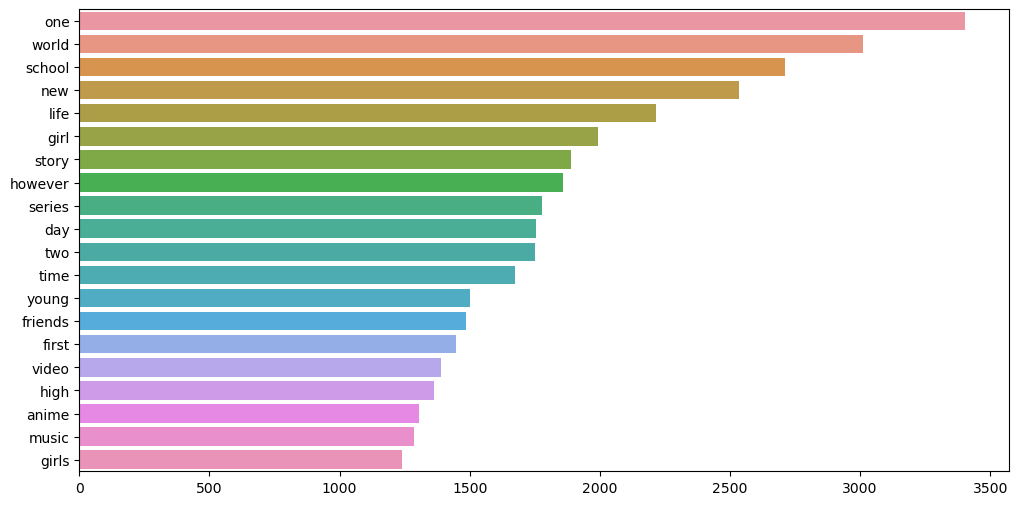

In [17]:
sns.barplot(x=values[:20], y=tmp[:20])

In [18]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

for _ in range(5):
    # Assuming df['genrelist'] contains the multi-label genre information
    multilabel_binarizer = MultiLabelBinarizer()
    multilabel_binarizer.fit(df['genrelist'])
    y = multilabel_binarizer.transform(df['genrelist'])

    # Split the data into training and testing sets
    xtrain, xtest, ytrain, ytest = train_test_split(df['cleaned_syn'], y, test_size=0.2)

    # Initialize and fit the TF-IDF vectorizer
    tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=10000)
    xtrain_tfidf = tfidf_vectorizer.fit_transform(xtrain)
    xtest_tfidf = tfidf_vectorizer.transform(xtest)

    # Initialize and train the Logistic Regression classifier
    model = LogisticRegression()
    classif = OneVsRestClassifier(model)
    classif.fit(xtrain_tfidf, ytrain)

    # Predict on the test set
    y_pred = classif.predict(xtest_tfidf)
    y_pred_prob = classif.predict_proba(xtest_tfidf)
    y_pred_new = (y_pred_prob >= 0.20).astype(int)

    # Calculate evaluation metrics
    accuracy = accuracy_score(ytest, y_pred)
    precision = precision_score(ytest, y_pred_new, average='micro')
    recall = recall_score(ytest, y_pred_new, average='micro')
    f1 = f1_score(ytest, y_pred_new, average='micro')

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}\n")


Accuracy: 0.1020
Precision: 0.4826
Recall: 0.5540
F1 Score: 0.5159

Accuracy: 0.0984
Precision: 0.4928
Recall: 0.5561
F1 Score: 0.5225

Accuracy: 0.1017
Precision: 0.4858
Recall: 0.5563
F1 Score: 0.5187

Accuracy: 0.1060
Precision: 0.4993
Recall: 0.5673
F1 Score: 0.5311

Accuracy: 0.1171
Precision: 0.4829
Recall: 0.5665
F1 Score: 0.5213

